$$\text{Notebook de recherche nettoyé pour le developpement de la partie intelligence articielle du projet à des fins de prédictions de sentiments}$$

$$\text{Import des modules}$$

In [2]:
from collections import Counter
import numpy as np
import os.path 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt 
import pandas as pd 
import pickle5 as pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob

import Traitement_text as TT

$$\text{Lecture du dataset et exploration du dataset}$$

In [3]:
df= pd.read_csv(r"D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\Data\dataset_emotion.csv")

In [4]:
df.describe

<bound method NDFrame.describe of        Sl no                                             Tweets  \
0          1   #1: @fe ed "RT @MirayaDizon1: Time is ticking...   
1          2   #2: @蓮花 &はすか ed "RT @ninjaryugo: ＃コナモンの日 だそうで...   
2          3   #3: @Ris ♡ ed "Happy birthday to one smokin h...   
3          4   #4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...   
4          5   #5: @Madhurima wth u vc♥ ed "Good morning dea...   
...      ...                                                ...   
10012  10016  Tweet #85: @Matteo tweeted "@GameSpot @Frannkc...   
10013  10017  Tweet #86: @𝐚𝐧𝐢𝐬𝐭𝐨𝐧 tweeted "@BRATgiirl_ that’...   
10014  10018  Tweet #87: @Chowkidar Ricky Sharma tweeted "@M...   
10015  10019  Tweet #88: @Katoe.EXE tweeted "u know what i h...   
10016  10019  Tweet #88: @Katoe.EXE tweeted "u know what i h...   

          Search key Feeling  
0      happy moments   happy  
1      happy moments   happy  
2      happy moments   happy  
3      happy moments   happy  
4     

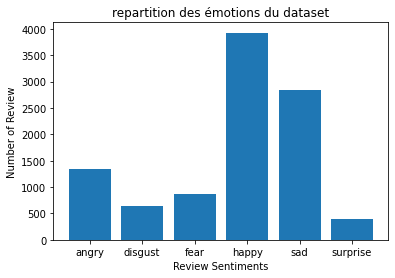

In [5]:
Sentiment_val=df.groupby('Feeling').count()
plt.bar(Sentiment_val.index.values, Sentiment_val['Tweets'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.title("repartition des émotions du dataset")
plt.show()#on voit ainsi que le dataset est très déséquilibré

$$\text{Traitement du dataframe}$$

In [18]:
def preprocessing(df): 
    df.drop("Sl no",inplace=True,axis=1)
    df.rename(columns={"Tweets":"tweet"},inplace=True)## on renomme la colonne à des fins de concordance avec nos autres datasets
    df["treaty_text"]=df["tweet"].map(TT.Prepro_Text)## traitement du texte 
    return df

In [26]:
def encoding(df):## on encode nos sentiments en des catégories interprétables par la machine 
    global pipe,LE 
    pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2),max_features=1100,strip_accents='unicode'))#,TruncatedSVD(n_components=300))
    text_tf= pipe.fit_transform(df['treaty_text'])
    x=text_tf
    LE = LabelEncoder()# Création d'un encoder
    LE.fit(df["Feeling"])
    y= LE.fit_transform(df['Feeling'])
    return x,y

In [8]:
def oversampling(x,y):
    oversample=SMOTE() ## chargement d'un transformateur pour équilibrer le dataset que nous possédons
    x_over,y_over=oversample.fit_resample(x,y)##équilibre le dataset en faisant de l'oversampling 
    return x_over,y_over

In [9]:
def undersampling(x,y): 
    undersample = RandomUnderSampler(random_state=0)
    x_under, y_under = undersample.fit_resample(x, y)
    return x_under,y_under

In [66]:
df=preprocessing(df)
x,y= encoding(df)
x_over,y_over= oversampling(x,y)
x_under,y_under= undersampling(x,y)

# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1) # on sépare le jeu de données en un train_set et test_set
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(x_over,y_over, test_size=0.2, random_state=1)## pareil pour la version oversampler afin de comparer les comportements

x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(x_under,y_under, test_size=0.2, random_state=1)## pareil pour la version undersampler afin de comparer les comportements

In [10]:
print("Répartition des émotions dans le dataset original",np.unique(y,return_counts=True)[1])## on voit que le jeu est deséquilibré 
print("Répartition des émotions dans le dataset oversampler",np.unique(y_over,return_counts=True)[1])## on voit que le jeu est équilibré et oversampler
print("Répartition des émotions dans le dataset undersampler",np.unique(y_under,return_counts=True)[1])## on voit que le jeu est équilibré et undersampler

Répartition des émotions dans le dataset original [1341  637  863 3928 2849  399]
Répartitio, des émotions dans le dataset oversampler [3928 3928 3928 3928 3928 3928]
Répartition des émotions dans le dataset undersampler [399 399 399 399 399 399]


$$\text{En résumé, l’algorithme SMOTE consiste à créer des exemples pour la classe sous-représentée. On choisit un de ces exemplesX. Pour cet X, on calcule ses k plus proches voisins dans la base d’apprentissage, toutes classes comprises. On choisit un  voisin aléatoire V parmi les k voisins. On tire un nombre aléaloire h\in]0,1]. Le nouvel élément ajouté à la base d’apprentissage est X + h (V-X) et il est associé à la classe sous-représentée. On continue jusqu’à la proportion souhaitée.}$$



In [11]:
liste_model=[DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]

In [45]:
def  model_Evaluate(model,X_train,X_test,y_train,y_test):## fonction qui permet d'évaluer un modèle --> utiliser sur une liste de modèle à des fins de comparaison 
    
    #Training the model
    model.fit(X_train,y_train)

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    N, train_score, val_score = learning_curve(model, X_train, y_train,train_sizes=np.linspace(0.1, 1, 5), cv=3)## on fait varier le train size en % pour savoir combien de données N il nous faut n_jobs nombres de coeurs pour le calcul 

    plt.subplot(1,1,1)
    plt.plot(N, train_score.mean(axis=1), label='train',c="orange")
    plt.plot(N, val_score.mean(axis=1), label='validation',c="r")
    plt.xlabel('train_sizes')
    plt.legend()
    plt.show()

    print(classification_report(y_test, y_pred))
    
    score = round(accuracy_score(y_test,y_pred)*100,2)
    print("Accuracy score:",score)

    # # Compute and plot the Confusion matrix
    cf_matrix_o = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix_o, cmap = 'Blues')
    plt.show()

    print("Répartition des émotions prédites",np.unique(y_pred,return_counts=True)[1])

$$\text{étude des modèles sur le dataset équilibré oversampler}$$

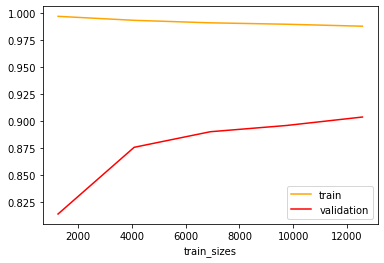

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       760
           1       0.98      0.97      0.98       805
           2       0.94      0.93      0.94       814
           3       0.84      0.85      0.84       826
           4       0.86      0.88      0.87       760
           5       0.94      0.95      0.95       749

    accuracy                           0.92      4714
   macro avg       0.92      0.92      0.92      4714
weighted avg       0.92      0.92      0.92      4714

Accuracy score: 91.83


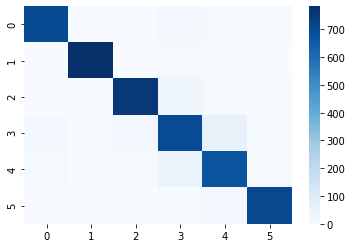

Répartition des émotions prédites [745 795 803 840 778 753]


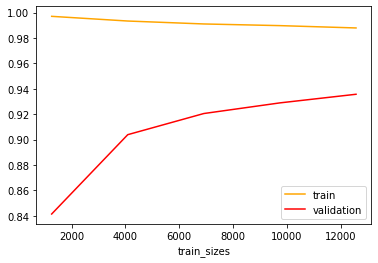

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       760
           1       1.00      0.98      0.99       805
           2       0.97      0.95      0.96       814
           3       0.84      0.94      0.89       826
           4       0.94      0.89      0.91       760
           5       0.95      0.96      0.95       749

    accuracy                           0.94      4714
   macro avg       0.95      0.94      0.94      4714
weighted avg       0.95      0.94      0.94      4714

Accuracy score: 94.34


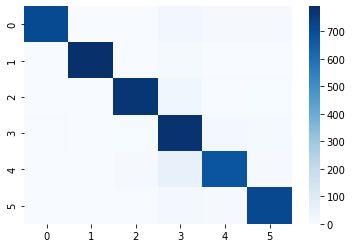

Répartition des émotions prédites [721 793 796 923 723 758]


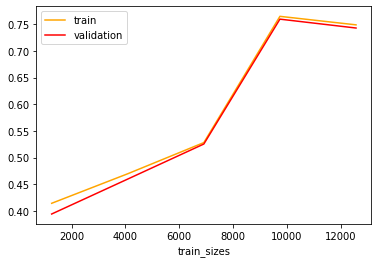

              precision    recall  f1-score   support

           0       0.96      0.72      0.83       760
           1       0.91      0.94      0.92       805
           2       0.97      0.76      0.86       814
           3       0.51      0.87      0.64       826
           4       0.65      0.48      0.55       760
           5       0.94      0.91      0.92       749

    accuracy                           0.78      4714
   macro avg       0.83      0.78      0.79      4714
weighted avg       0.82      0.78      0.79      4714

Accuracy score: 78.13


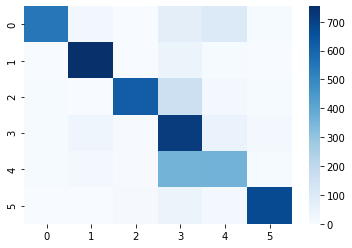

Répartition des émotions prédites [ 572  825  638 1403  556  720]


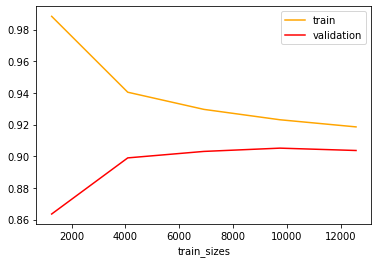

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       760
           1       0.99      0.95      0.97       805
           2       0.99      0.86      0.92       814
           3       0.69      0.96      0.80       826
           4       0.97      0.83      0.89       760
           5       0.95      0.94      0.95       749

    accuracy                           0.91      4714
   macro avg       0.93      0.91      0.91      4714
weighted avg       0.93      0.91      0.91      4714

Accuracy score: 90.73


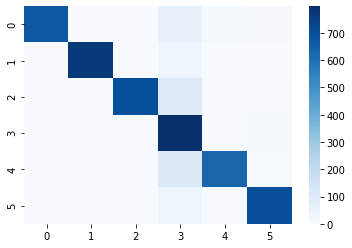

Répartition des émotions prédites [ 680  773  710 1156  651  744]


In [16]:
for model_challenger in liste_model :
    model_Evaluate(model_challenger,x_train_o,x_test_o,y_train_o,y_test_o)

$$\text{étude des modèles pour le dataset équilibré undersampler}$$

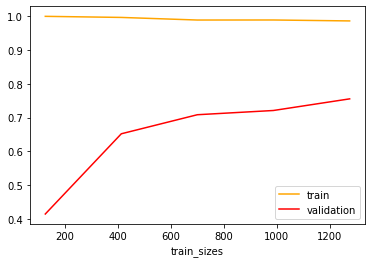

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        68
           1       0.87      0.93      0.90        85
           2       0.79      0.77      0.78        78
           3       0.59      0.62      0.61        88
           4       0.76      0.73      0.75        79
           5       0.79      0.67      0.72        81

    accuracy                           0.76       479
   macro avg       0.76      0.76      0.76       479
weighted avg       0.76      0.76      0.76       479

Accuracy score: 75.57


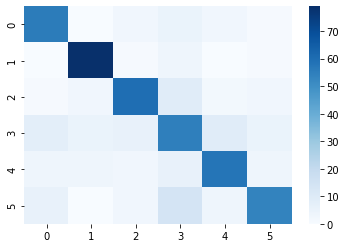

Répartition des émotions prédites [75 91 76 93 76 68]


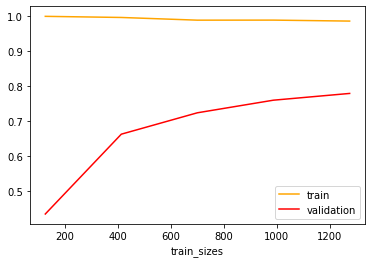

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        68
           1       0.98      0.94      0.96        85
           2       0.83      0.77      0.80        78
           3       0.59      0.86      0.70        88
           4       0.92      0.72      0.81        79
           5       0.83      0.73      0.78        81

    accuracy                           0.81       479
   macro avg       0.84      0.81      0.82       479
weighted avg       0.84      0.81      0.82       479

Accuracy score: 81.21


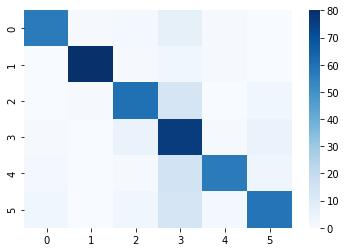

Répartition des émotions prédites [ 63  82  72 129  62  71]


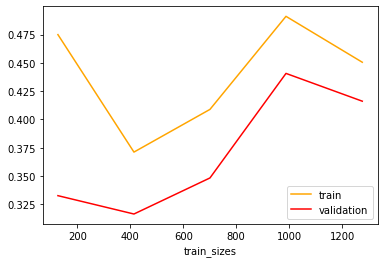

              precision    recall  f1-score   support

           0       0.21      0.25      0.23        68
           1       0.89      0.65      0.75        85
           2       0.22      0.73      0.33        78
           3       0.22      0.10      0.14        88
           4       0.50      0.01      0.02        79
           5       0.71      0.27      0.39        81

    accuracy                           0.34       479
   macro avg       0.46      0.34      0.31       479
weighted avg       0.47      0.34      0.32       479

Accuracy score: 33.61


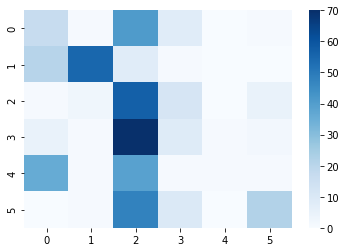

Répartition des émotions prédites [ 80  62 263  41   2  31]


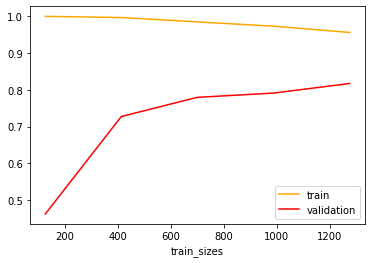

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        68
           1       0.97      0.92      0.95        85
           2       0.89      0.76      0.82        78
           3       0.60      0.83      0.70        88
           4       0.92      0.75      0.83        79
           5       0.78      0.81      0.80        81

    accuracy                           0.81       479
   macro avg       0.84      0.81      0.82       479
weighted avg       0.84      0.81      0.82       479

Accuracy score: 81.42


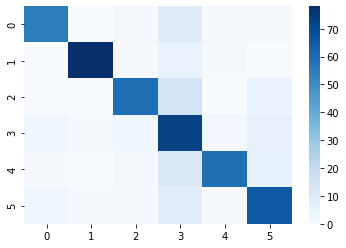

Répartition des émotions prédites [ 62  80  66 122  64  85]


In [17]:
for model_challenger in liste_model : 
    model_Evaluate(model_challenger,x_train_u,x_test_u,y_train_u,y_test_u)

$$\text{On peut alors après choix du modèle, faire de l'optimisation des hyperparamètres en utilisant GridSearchCV}$$ 

In [18]:
param_grid={'n_estimators':np.arange(186,200,2)}## création du dictionnaire des paramètres que va faire varier le gridsearchcv 
grid=GridSearchCV(RandomForestClassifier(),param_grid,cv=3)# on crée la grid 
grid.fit(x_train_o,y_train_o)# on entraine la grid
print("le meilleur score parmi les différents hyperparamètres passés avec le train_set",grid.best_score_)## on affiche le meilleur score
print("L'hyperparamètre qui permet d'obtenir le meilleur score ",grid.best_params_)## on affiche les meilleurs paramètres
dt=grid.best_estimator_##on enregistre le modèle avec le meilleur score
print("On affiche le score du meilleur modèle avec le test_set ",dt.score(x_test_o,y_test_o))# on affiche le score du meilleur modèle

le meilleur score parmi les différents hyperparamètres passés avec le train_set 0.9366710435986652
L'hyperparamètre qui permet d'obtenir le meilleur score  {'n_estimators': 194}
On affiche le score du meilleur modèle avec le test_set  0.9437844717861689


In [19]:
# dt.fit(x_train_o,y_train_o)## on entraine le modèle 
preddt_o = dt.predict(x_test_o)## on fait les prédictions

Confusion Matrix for Decision Tree:
[[710   0   2  26  12  10]
 [  0 791   0  14   0   0]
 [  2   0 772  28   4   8]
 [  4   1   9 777  22  13]
 [  1   1   9  59 680  10]
 [  0   0   2  17  11 719]]


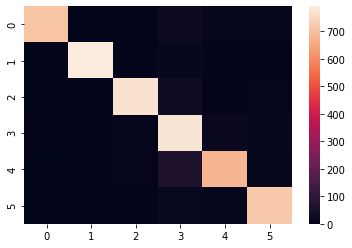

In [20]:
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test_o,preddt_o))
sns.heatmap(confusion_matrix(y_test_o,preddt_o))
plt.show()

In [21]:
score = round(accuracy_score(y_test_o,preddt_o)*100,2)
print("Score:",score)

Score: 94.38


In [22]:
print("Classification Report:")
print(classification_report(y_test_o,preddt_o))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       760
           1       1.00      0.98      0.99       805
           2       0.97      0.95      0.96       814
           3       0.84      0.94      0.89       826
           4       0.93      0.89      0.91       760
           5       0.95      0.96      0.95       749

    accuracy                           0.94      4714
   macro avg       0.95      0.94      0.94      4714
weighted avg       0.95      0.94      0.94      4714



In [23]:
# model_Evaluate(dt)

$$\text{Les learning curves ainsi que les classifications reports nous permettent de voir que notre modèle est bien entrainé et que la version equilibrée et oversampler du dataset permet de meilleures perfomances du modèle.}$$ 

$$\text{On peut à présent sauvegarder l'encoder, la pipeline et le meilleur modèle issus de notre recherche, qui sont tous entrainés}$$ 

In [24]:

file = open((r'D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\my_models\PipeLine.pickle'),'wb')
pickle.dump(pipe, file)
file.close()

file = open(r'D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\my_models\Label_Encoder.pickle','wb')
pickle.dump(LE, file)
file.close()

file = open(r'D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\my_models\My_Model_Test.pickle','wb')
pickle.dump(dt, file)
file.close()

$$\text{ Tentative de mise en place du solution de KNN pour labaliser des tweets et avoir un dataset plus gros}$$

In [15]:
nouveau_train=pd.read_csv(r"D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\Data\train.csv")

In [16]:
nouveau_train.describe

<bound method NDFrame.describe of           id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]>

In [52]:
def preprocessing_knn(df): 
    df["treaty_text"]=df["tweet"].map(TT.Prepro_Text)## traitement du texte 
    return df

In [19]:
## A ne lancer qu'une seule fois 
# nouveau_train.dropna(inplace=True)
# nouveau_train =preprocessing_knn(nouveau_train)
# nouveau_train.to_csv(r"D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\Data\train.csv")## comme ça je fais le prepro une seule fois

In [51]:
def encoding_knn(df):## on encode nos sentiments en des catégories interprétables par la machine 
    pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2),max_features=1100,strip_accents='unicode'))#,TruncatedSVD(n_components=300))
    text_tf= pipe.fit_transform(df['treaty_text'])
    x=text_tf
    return x

In [24]:
df_knn=pd.read_csv(r"D:\CS_1A\Coding_Weeks\Livrable\analyse_sentiment_twitter\Data\train.csv")
df_knn.dropna(inplace=True)# on supprime les none values

In [92]:
neigh = KNeighborsClassifier(n_neighbors=35)# on connait d'ores et déjà le numbre de classe
neigh.fit(x_train_u,y_train_u)## on l'entraine avec nos données labelisées
print(neigh.score(x_test_o,y_test_o))

0.7581671616461604


In [91]:
param_grid={'n_neighbors':np.arange(1,50,2)}## création du dictionnaire des paramètres que va faire varier le gridsearchcv 
grid_KNN=GridSearchCV(KNeighborsClassifier(),param_grid,cv=4)# on crée la grid 
grid_KNN.fit(x_train_u,y_train_u)# on entraine la grid
print("le meilleur score parmi les différents hyperparamètres passés avec le train_set",grid_KNN.best_score_)## on affiche le meilleur score
print("L'hyperparamètre qui permet d'obtenir le meilleur score ",grid_KNN.best_params_)## on affiche les meilleurs paramètres
dt_KNN=grid_KNN.best_estimator_##on enregistre le modèle avec le meilleur score
print("On affiche le score du meilleur modèle avec le test_set ",dt_KNN.score(x_test_o,y_test_o))# on affiche le score du meilleur modèle

le meilleur score parmi les différents hyperparamètres passés avec le train_set 0.712275399411256
L'hyperparamètre qui permet d'obtenir le meilleur score  {'n_neighbors': 33}
On affiche le score du meilleur modèle avec le test_set  0.759439966058549


In [93]:
x_knn= encoding_knn(df_knn)# on encode
y_pred_knn=dt_KNN.predict(x_knn)#on fait la prédiction

In [94]:
print(np.unique(y_pred_knn,return_counts=True)[1])# on regarde la répartition

[10462  4786  5058  4913  3512  3226]


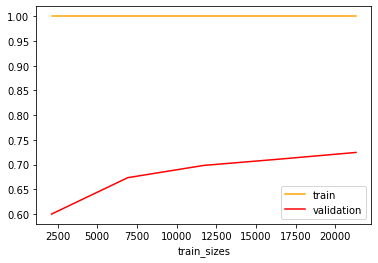

              precision    recall  f1-score   support

           0       0.38      0.70      0.49       760
           1       0.84      0.85      0.84       805
           2       0.86      0.69      0.77       814
           3       0.70      0.30      0.42       826
           4       0.70      0.34      0.46       760
           5       0.63      0.93      0.75       749

    accuracy                           0.63      4714
   macro avg       0.68      0.64      0.62      4714
weighted avg       0.69      0.63      0.62      4714

Accuracy score: 63.43


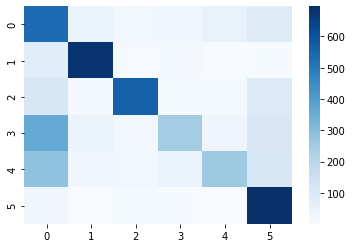

Répartition des émotions prédites [1406  815  653  359  374 1107]


In [85]:
modele_with_knn=RandomForestClassifier(n_estimators=180)# le modèle
model_Evaluate(modele_with_knn,x_knn,x_test_o,y_pred_knn,y_test_o)# on l'évalue

$$\text{On peut voir ici que les prédictions ne sont pas améliorées.}$$